In [1]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

    

import torchvision
import torchvision.transforms as transforms


from models import *   # bring everything in the folder models

global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')
    
    
batch_size = 128

model_name = "VGG16_quant"
model = VGG16_quant()
print(model)

        
normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])



train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 100 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()  # measure current time
    
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True) # topk(k, dim=None, largest=True, sorted=True)
                                               # will output (max value, its index)
    pred = pred.t()           # transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))   # "-1": calculate automatically

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)  # view(-1): make a flattened 1D tensor
        res.append(correct_k.mul_(100.0 / batch_size))   # correct: size of [maxk, batch_size]
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [20, 55]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1        

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

=> Building model...
VGG_quant(
  (features): Sequential(
    (0): QuantConv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): QuantConv2d(
      64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): QuantConv2d(
      64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): QuantConv2d(
      128, 128, kernel_size=(3, 3), stride

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


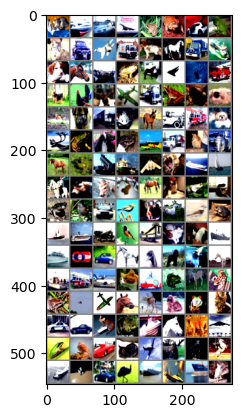

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images))


In [3]:
# This cell is from the website

lr = 0.01
weight_decay = 0.001
epochs = 100
best_prec = 0

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')
    
fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train(trainloader, model, criterion, optimizer, epoch)
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    

Epoch: [0][0/391]	Time 3.959 (3.959)	Data 0.866 (0.866)	Loss 2.5671 (2.5671)	Prec 9.375% (9.375%)
Epoch: [0][100/391]	Time 0.045 (0.090)	Data 0.002 (0.012)	Loss 2.1698 (2.0237)	Prec 28.906% (26.694%)
Epoch: [0][200/391]	Time 0.045 (0.071)	Data 0.002 (0.010)	Loss 1.5389 (1.8466)	Prec 40.625% (32.867%)
Epoch: [0][300/391]	Time 0.041 (0.063)	Data 0.002 (0.008)	Loss 1.3023 (1.7146)	Prec 53.125% (37.627%)
Validation starts
Test: [0/79]	Time 0.569 (0.569)	Loss 1.3726 (1.3726)	Prec 53.906% (53.906%)
 * Prec 51.480% 
best acc: 51.480000
Epoch: [1][0/391]	Time 1.051 (1.051)	Data 1.009 (1.009)	Loss 1.3029 (1.3029)	Prec 48.438% (48.438%)
Epoch: [1][100/391]	Time 0.045 (0.065)	Data 0.001 (0.025)	Loss 1.0355 (1.2260)	Prec 60.938% (56.010%)
Epoch: [1][200/391]	Time 0.051 (0.058)	Data 0.001 (0.018)	Loss 1.0864 (1.1865)	Prec 62.500% (57.210%)
Epoch: [1][300/391]	Time 0.045 (0.056)	Data 0.002 (0.015)	Loss 0.9298 (1.1521)	Prec 68.750% (58.749%)
Validation starts
Test: [0/79]	Time 0.608 (0.608)	Loss 1.16

In [4]:
PATH = "result/VGG16_quant/model_best.pth.tar"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])
device = torch.device("cuda") 

model.cuda()
model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device) # loading to GPU
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(testloader.dataset)

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


Test set: Accuracy: 9097/10000 (91%)



In [5]:
# HW

#  1. train resnet20 and vgg16 to achieve >90% accuracy 
#  2. save your trained model in the result folder 
#  3. Restart your jupyter notebook by "Kernel - Restart & Clear Output"
#  4. Load your saved model for vgg16 and validate to see the accuracy
#  5. such as the last part of "[W2S2_example2]_CNN_for_MNIST.ipynb", prehook the input layers of all the conv layers.
#  6. from the first prehooked input, compute to get the second prehooked input. 
#  7. Compare your computed second input vs. the prehooked second input.



In [6]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
    def __call__(self, module, module_in):
        self.outputs.append(module_in)
    def clear(self):
        self.outputs = []

# Instantiate SaveOutput
save_output = SaveOutput()

# Register pre-hooks to capture inputs for each Conv2d layer
for layer in model.modules():   
    if isinstance(layer, torch.nn.Conv2d):
        print("prehooked")
        layer.register_forward_pre_hook(save_output)

# Move model and data to the appropriate device (GPU/CPU)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
model.to(device)

# Run forward pass
out = model(images)

# Print all saved outputs and their shapes
for idx, output in enumerate(save_output.outputs):
    print(f"Output {idx}:")
    if output[0] is not None:  # Check if the output is not None
        print(f"Shape: {output[0].shape}")
    else:
        print("None")


prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
prehooked
Output 0:
Shape: torch.Size([128, 3, 32, 32])
Output 1:
Shape: torch.Size([128, 64, 32, 32])
Output 2:
Shape: torch.Size([128, 64, 16, 16])
Output 3:
Shape: torch.Size([128, 128, 16, 16])
Output 4:
Shape: torch.Size([128, 128, 8, 8])
Output 5:
Shape: torch.Size([128, 256, 8, 8])
Output 6:
Shape: torch.Size([128, 256, 8, 8])
Output 7:
Shape: torch.Size([128, 256, 4, 4])
Output 8:
Shape: torch.Size([128, 8, 4, 4])
Output 9:
Shape: torch.Size([128, 8, 4, 4])
Output 10:
Shape: torch.Size([128, 512, 2, 2])
Output 11:
Shape: torch.Size([128, 512, 2, 2])
Output 12:
Shape: torch.Size([128, 512, 2, 2])


In [ ]:
x_bit = 4

x = save_output.outputs[8][0] #from above printing the saved outputs we want to grab output 8 since the size matches and it is the correct input
#output 9 is the Relu, so thats why it does not change the shape

x_alpha = model.features[27].act_alpha #grab corresponding alpha

print ("X", x)
print ("X_Alpha", x_alpha)


x_delta = (x_alpha) / ((2**x_bit - 1))  

act_quant_fn = act_quantization(x_bit)  
x_q = act_quant_fn(x, x_alpha)  

x_int = (x_q / x_delta)  #return 4 bit quantized x


In [ ]:
##4bit quantizing the weights 

w_bit = 4
weight_q = model.features[27].weight_q

 # quantized value is stored during the training
w_alpha = model.features[27].weight_quant.wgt_alpha
   # alpha is defined in your model already. bring it out here
w_delta = (w_alpha) / ((2**w_bit-1)-1)   # delta can be calculated by using alpha and w_bit
weight_int = (weight_q / w_delta) # w_int can be calculated by weight_q and w_delta
print(weight_int) # you should see clean integer numbers

In [22]:
conv_int = torch.nn.Conv2d(in_channels = 8, out_channels=8, kernel_size = 3, padding=1, bias=False)
#add padding to have the same size
conv_int.weight = torch.nn.parameter.Parameter(weight_int)
output_int =  conv_int(x_int)    # output_int can be calculated with conv_int and x_int
output_recovered = output_int * (x_delta * w_delta)  # recover with x_delta and w_delta
#print(output_recovered)

In [23]:
#### input floating number / weight quantized version

conv_ref = torch.nn.Conv2d(in_channels = 8, out_channels=8, kernel_size = 3, padding =1, bias = False)
conv_ref.weight = model.features[27].weight_q

output_ref = conv_ref(x)
#print(output_ref)

In [24]:
difference = abs( output_ref - output_recovered )
print(difference.mean())  ## It should be small, e.g.,2.3 in my trainned model

tensor(0.2084, device='cuda:0', grad_fn=<MeanBackward0>)


In [27]:
relu_output = model.features[28](output_recovered) 


print("Shape of output from layer 8:", save_output.outputs[8][0].shape)
print("Shape of save_output.outputs[9][0]:", save_output.outputs[9][0].shape)
print("Shape of output from layer 10:", save_output.outputs[10][0].shape)
print("Shape of relu_output:", relu_output.shape)
difference = abs(save_output.outputs[9][0] - relu_output ) 
print(difference.mean()) ## It should be small


Shape of output from layer 8: torch.Size([128, 8, 4, 4])
Shape of output from layer 10: torch.Size([128, 512, 2, 2])
Shape of save_output.outputs[9][0]: torch.Size([128, 8, 4, 4])
Shape of relu_output: torch.Size([128, 8, 4, 4])
tensor(2.1905e-07, device='cuda:0', grad_fn=<MeanBackward0>)


In [15]:
import os
import numpy as np


project_folder = "Inputs"  # Modify this path if your project folder is located elsewhere

# Ensure the project folder exists
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

# Save quantized activations (x_int) to a text file
x_file_path = os.path.join(project_folder, "x_quant_values.txt")
with open(x_file_path, "w") as x_file:
    # Assuming x_int is a PyTorch tensor, convert it to a numpy array
    x_int_np = x_int.detach().cpu().numpy() if x_int.is_cuda else x_int.numpy()
    np.savetxt(x_file, x_int_np.reshape(-1), fmt="%d")  # Flatten the array and save as integers
print(f"Quantized activations saved to {x_file_path}")

# Save quantized weights (weight_int) to a text file
w_file_path = os.path.join(project_folder, "w_quant_values.txt")
with open(w_file_path, "w") as w_file:
    # Assuming weight_int is a PyTorch tensor, convert it to a numpy array
    weight_int_np = weight_int.detach().cpu().numpy()if weight_int.is_cuda else weight_int.numpy()
    np.savetxt(w_file, weight_int_np.reshape(-1), fmt="%d")  # Flatten the array and save as integers
print(f"Quantized weights saved to {w_file_path}")


Quantized activations saved to Inputs/x_quant_values.txt
Quantized weights saved to Inputs/w_quant_values.txt


In [ ]:
print(